In [1]:
import scipy.io
import matplotlib
from scipy.io import loadmat
import numpy as np
import pickle
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Activation, Flatten
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

**DATA LOADING**

In [3]:
!pip install kaggle --upgrade
!mkdir ".kaggle"
!mkdir /root/.kaggle/

In [4]:
import json
token = {"username":"avishek1504018","key":"6b07513adf28d0ccf71b5b340c3d332d"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!cp /content/.kaggle/kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d inancigdem/eeg-data-for-mental-attention-state-detection  -p /content
!unzip /content/eeg-data-for-mental-attention-state-detection.zip

 97% 542M/557M [00:03<00:00, 138MB/s]
100% 557M/557M [00:04<00:00, 143MB/s]
Archive:  /content/eeg-data-for-mental-attention-state-detection.zip
  inflating: EEG Data/eeg_record1.mat  
  inflating: EEG Data/eeg_record10.mat  
  inflating: EEG Data/eeg_record11.mat  
  inflating: EEG Data/eeg_record12.mat  
  inflating: EEG Data/eeg_record13.mat  
  inflating: EEG Data/eeg_record14.mat  
  inflating: EEG Data/eeg_record15.mat  
  inflating: EEG Data/eeg_record16.mat  
  inflating: EEG Data/eeg_record17.mat  
  inflating: EEG Data/eeg_record18.mat  
  inflating: EEG Data/eeg_record19.mat  
  inflating: EEG Data/eeg_record2.mat  
  inflating: EEG Data/eeg_record20.mat  
  inflating: EEG Data/eeg_record21.mat  
  inflating: EEG Data/eeg_record22.mat  
  inflating: EEG Data/eeg_record23.mat  
  inflating: EEG Data/eeg_record24.mat  
  inflating: EEG Data/eeg_record25.mat  
  inflating: EEG Data/eeg_record26.mat  
  inflating: EEG Data/eeg_record27.mat  
  inflating: EEG Data/eeg_record28.ma

In [5]:
inp_dir = '/content/EEG Data/' 

**LEVEL CALCULATION**

In [10]:
fs = 128 
n_subjects = 5
mkpt1 = int(fs*10*60)
mkpt2 = int(fs*20*60)
mkpt3 = int(fs*30*60)


**MAPPING**

In [11]:
subject_map = {}
for s in range(1, n_subjects+1):
    a =  int(7*(s-1)) + 3
    if s!=5:
        b = a + 5
    else:
        b = a + 4
    subject_map[s] = [i for i in range(a, b)]
print(subject_map)

{1: [3, 4, 5, 6, 7], 2: [10, 11, 12, 13, 14], 3: [17, 18, 19, 20, 21], 4: [24, 25, 26, 27, 28], 5: [31, 32, 33, 34]}


In [12]:
channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
useful_channels = ['F7','F3','P7','O1','O2','P8','AF4']
use_channel_inds = []
for c in useful_channels:
    if c in channels:
        use_channel_inds.append(channels.index(c))

**LEVEL ASSINGMENT & DATA SERIALIZATION**

In [14]:
for s in range(1, n_subjects+1):
    data = {}
    data['channels'] = useful_channels
    data['fs'] = fs
    for i, t in enumerate(subject_map[s]):
        trial = {}
        trial_data = loadmat(inp_dir + f'eeg_record{t}.mat')
        eeg = trial_data['o']['data'][0][0][:, 3:17]
        eeg = eeg[:, use_channel_inds]
        trial['Attentive'] = eeg[:mkpt1]
        trial['Inattentive'] = eeg[mkpt1:mkpt2]
       # trial['drowsed'] = eeg[mkpt2:]
        data[f'trial_{i+1}'] = trial
    with open(f'subject_{s}.pkl', 'wb') as f: 
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [15]:
with open('subject_1.pkl', 'rb') as f: 
    data = pickle.load(f)

In [16]:
print(type(data))
print(data.keys())
print(type(data['trial_1']))
print(data['trial_1'].keys())
print(len(data['trial_1']['Attentive']))
print(len(data['trial_1']["Inattentive"]))
print(type(data['trial_1']['Attentive']))

<class 'dict'>
dict_keys(['channels', 'fs', 'trial_1', 'trial_2', 'trial_3', 'trial_4', 'trial_5'])
<class 'dict'>
dict_keys(['Attentive', 'Inattentive'])
76800
76800
<class 'numpy.ndarray'>


In [17]:
print(data['trial_1'])

{'Attentive': array([[3804.1025641 , 5210.76923077, 4490.76923077, ..., 3511.79487179,
        4321.02564103, 4024.1025641 ],
       [3796.41025641, 5205.64102564, 4489.23076923, ..., 3505.12820513,
        4311.79487179, 4017.94871795],
       [3798.97435897, 5207.17948718, 4489.23076923, ..., 3511.79487179,
        4313.84615385, 4018.97435897],
       ...,
       [3751.79487179, 5245.12820513, 4540.51282051, ..., 3495.38461538,
        4321.02564103, 4151.28205128],
       [3738.46153846, 5231.28205128, 4525.64102564, ..., 3487.69230769,
        4304.1025641 , 4134.87179487],
       [3723.58974359, 5217.94871795, 4519.48717949, ..., 3481.53846154,
        4291.79487179, 4125.64102564]]), 'Inattentive': array([[3714.87179487, 5206.66666667, 4509.23076923, ..., 3477.94871795,
        4281.53846154, 4123.58974359],
       [3706.15384615, 5198.46153846, 4491.79487179, ..., 3470.76923077,
        4267.69230769, 4117.43589744],
       [3698.97435897, 5194.35897436, 4484.1025641 , ..., 346

In [ ]:
print(data['trial_1']['Attentive'].shape)
print(data['trial_1']["Inattentive"].shape)

print(data['trial_2']['Attentive'].shape)
print(data['trial_2']["Inattentive"].shape)

print(data['trial_3']['Attentive'].shape)
print(data['trial_3']["Inattentive"].shape)

print(data['trial_4']['Attentive'].shape)
print(data['trial_4']["Inattentive"].shape)

print(data['trial_5']['Attentive'].shape)
print(data['trial_5']["Inattentive"].shape)

(76800, 7)
(76800, 7)
(76800, 7)
(76800, 7)
(76800, 7)
(76800, 7)
(76800, 7)
(76800, 7)
(76800, 7)
(76800, 7)


In [ ]:
data

{'channels': ['F7', 'F3', 'P7', 'O1', 'O2', 'P8', 'AF4'],
 'fs': 128,
 'trial_1': {'Attentive': array([[3804.1025641 , 5210.76923077, 4490.76923077, ..., 3511.79487179,
          4321.02564103, 4024.1025641 ],
         [3796.41025641, 5205.64102564, 4489.23076923, ..., 3505.12820513,
          4311.79487179, 4017.94871795],
         [3798.97435897, 5207.17948718, 4489.23076923, ..., 3511.79487179,
          4313.84615385, 4018.97435897],
         ...,
         [3751.79487179, 5245.12820513, 4540.51282051, ..., 3495.38461538,
          4321.02564103, 4151.28205128],
         [3738.46153846, 5231.28205128, 4525.64102564, ..., 3487.69230769,
          4304.1025641 , 4134.87179487],
         [3723.58974359, 5217.94871795, 4519.48717949, ..., 3481.53846154,
          4291.79487179, 4125.64102564]]),
  'Inattentive': array([[3714.87179487, 5206.66666667, 4509.23076923, ..., 3477.94871795,
          4281.53846154, 4123.58974359],
         [3706.15384615, 5198.46153846, 4491.79487179, ..., 347

In [16]:
print(type(data['trial_1']['Inattentive'][0]))
print(data['trial_1']['Inattentive'][0])

<class 'numpy.ndarray'>
[3714.87179487 5206.66666667 4509.23076923 3871.79487179 3477.94871795
 4281.53846154 4123.58974359]


In [17]:
data['channels']

['F7', 'F3', 'P7', 'O1', 'O2', 'P8', 'AF4']

In [18]:
l = len(data['trial_1']['Attentive'])



**CONCATENATION**

In [19]:
new_array = np.concatenate([data['trial_1']['Attentive'],
                           data['trial_1']['Inattentive'],
                            data['trial_2']['Attentive'],
                            data['trial_2']['Inattentive'],
                            data['trial_3']['Attentive'],
                            data['trial_3']['Inattentive'],
                            data['trial_4']['Attentive'],
                            data['trial_4']['Inattentive'],
                            data['trial_5']['Attentive'],
                            data['trial_5']['Inattentive']])

df =  pd.DataFrame(new_array, columns=['F7','F3', 'P7', '01','02','P8','AF4'])

In [20]:
df

,F7,F3,P7,01,02,P8,AF4
0,3804.102564,5210.769231,4490.769231,3862.051282,3511.794872,4321.025641,4024.102564
1,3796.410256,5205.641026,4489.230769,3858.461538,3505.128205,4311.794872,4017.948718
2,3798.974359,5207.179487,4489.230769,3865.128205,3511.794872,4313.846154,4018.974359
3,3801.538462,5210.256410,4490.256410,3866.153846,3511.282051,4315.897436,4022.051282
4,3799.487179,5210.256410,4490.256410,3865.641026,3506.153846,4311.282051,4020.512821
...,...,...,...,...,...,...,...
767995,4012.820513,5053.333333,4296.923077,4309.230769,4082.051282,4198.974359,4137.948718
767996,4018.974359,5057.948718,4302.564103,4314.358974,4087.179487,4205.128205,4143.076923
767997,4019.487179,5062.564103,4303.076923,4313.846154,4090.256410,4205.641026,4138.974359
767998,4016.923077,5060.512821,4301.538462,4311.794872,4087.692308,4202.564103,4132.820513


In [21]:
Y = np.concatenate([np.ones(l),np.zeros(l),np.ones(l),np.zeros(l),np.ones(l),np.zeros(l),np.ones(l),np.zeros(l),np.ones(l),np.zeros(l)])
Y = np.expand_dims(Y, axis = 1)


**NORMALIZED**

In [22]:
normalized_df=(df-df.min())/(df.max()-df.min())

In [23]:
normalized_df

,F7,F3,P7,01,02,P8,AF4
0,0.359429,0.645575,0.568804,0.304497,0.379955,0.591160,0.093535
1,0.352043,0.641439,0.567870,0.301829,0.377027,0.580110,0.091945
2,0.354505,0.642680,0.567870,0.306784,0.379955,0.582566,0.092210
3,0.356967,0.645161,0.568493,0.307546,0.379730,0.585021,0.093005
4,0.354998,0.645161,0.568493,0.307165,0.377477,0.579497,0.092607
...,...,...,...,...,...,...,...
767995,0.559823,0.518610,0.451121,0.636814,0.630405,0.445058,0.122946
767996,0.565731,0.522333,0.454545,0.640625,0.632658,0.452425,0.124271
767997,0.566224,0.526055,0.454857,0.640244,0.634009,0.453039,0.123211
767998,0.563762,0.524400,0.453923,0.638720,0.632883,0.449355,0.121622


**TRAINING SPLIT**

In [24]:
#X_train, X_split(nor_test, y_train, y_test = train_testmalized_df, Y, train_size = 0.8)


x_train, x_test, y_train, y_test = train_test_split(normalized_df, Y, train_size=0.8)

In [26]:
print(y_train)
print(x_train.shape)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
(614400, 7)


**MAIN MODEL**

In [26]:
input = keras.Input(shape=(x_train.shape[1]))
layer = tf.expand_dims(input,axis = 2)
layer = LSTM(30, return_sequences=True, stateful=False)(layer)
layer = Dropout(0.5)(layer)
layer = (BatchNormalization())(layer)
layer = LSTM(30, return_sequences=True, stateful=False)(layer)
layer = Dropout(0.3)(layer)
layer = BatchNormalization()(layer)
#layer = Flatten()(layer)
layer = LSTM(20, return_sequences=True, stateful=False)(layer)
layer = Dropout(0.3)(layer)
layer = BatchNormalization()(layer)
#layer = Flatten()(layer)
layer = LSTM(20, return_sequences=True, stateful=False)(layer)
layer = Dropout(0.3)(layer)
layer = BatchNormalization()(layer)
layer = Flatten()(layer)
out = keras.layers.Dense(1, activation = 'sigmoid')(layer)


model = keras.Model(inputs = input, outputs = out)

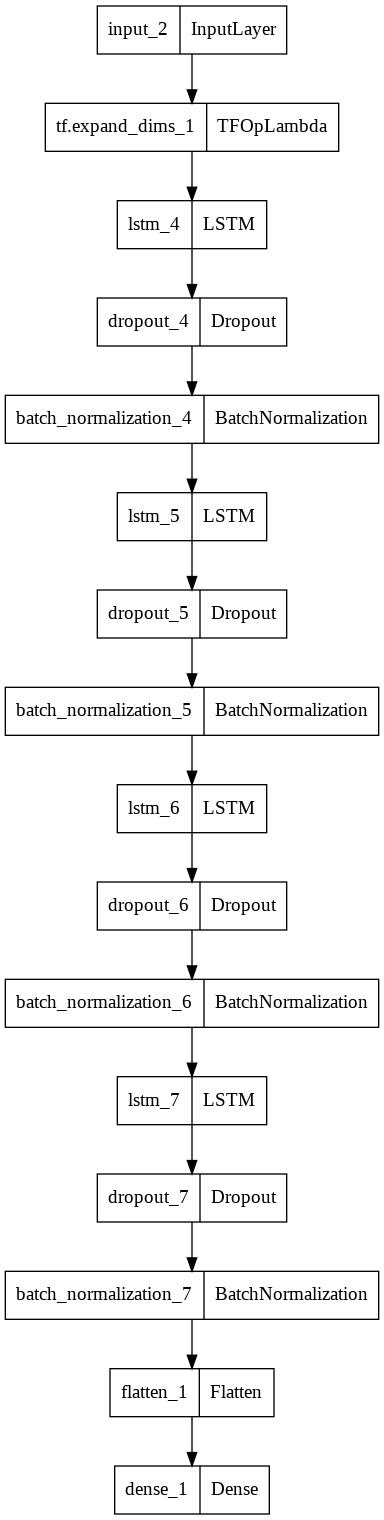

In [27]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [28]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['acc']  
              )


hist = model.fit(x_train,y_train, validation_split = 0.2,batch_size = 100, epochs = 30)

Epoch 1/30
4916/4916 [==============================] - 129s 25ms/step - loss: 0.6998 - acc: 0.5048 - val_loss: 0.6997 - val_acc: 0.4996
Epoch 2/30
4916/4916 [==============================] - 117s 24ms/step - loss: 0.6613 - acc: 0.5892 - val_loss: 0.5966 - val_acc: 0.6727
Epoch 3/30
4916/4916 [==============================] - 119s 24ms/step - loss: 0.6083 - acc: 0.6566 - val_loss: 0.5566 - val_acc: 0.7024
Epoch 4/30
4916/4916 [==============================] - 118s 24ms/step - loss: 0.5880 - acc: 0.6742 - val_loss: 0.5332 - val_acc: 0.7109
Epoch 5/30
4916/4916 [==============================] - 118s 24ms/step - loss: 0.5761 - acc: 0.6843 - val_loss: 0.5351 - val_acc: 0.7172
Epoch 6/30
4916/4916 [==============================] - 119s 24ms/step - loss: 0.5619 - acc: 0.6958 - val_loss: 0.5135 - val_acc: 0.7272
Epoch 7/30
4916/4916 [==============================] - 120s 24ms/step - loss: 0.5474 - acc: 0.7069 - val_loss: 0.4992 - val_acc: 0.7383
Epoch 8/30
4916/4916 [===================

In [29]:
test_acc = model.evaluate(x_test,y_test)
print(test_acc)

4800/4800 [==============================] - 28s 6ms/step - loss: 0.4062 - acc: 0.8041
[0.4061506688594818, 0.8041406273841858]


In [30]:
y_pred = np.round(model.predict(x_test))

In [31]:
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)

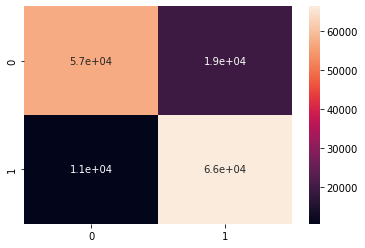

In [32]:
sns.color_palette("light:#5A9", as_cmap=True)
sns.heatmap(cm, annot=True)